In [4]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np

In [5]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('./configs/custom/final.py')
root='../dataset/'

epoch = 'latest'


cfg.data.test.test_mode = True

cfg.data.samples_per_gpu = 4

cfg.seed=2021
cfg.gpu_ids = [1]
cfg.work_dir = './work_dirs/swin_trash'

cfg.model.roi_head.bbox_head.num_classes = 10

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

In [6]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'{epoch}.pth')

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg')) # build detector
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') # ckpt load

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])


/opt/ml/detection/new_mmdetection/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


In [8]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05) # output 계산

[                                ] 3/4871, 3.1 task/s, elapsed: 1s, ETA:  1574s

/opt/ml/detection/new_mmdetection/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/opt/ml/detection/new_mmdetection/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4871/4871, 14.4 task/s, elapsed: 338s, ETA:     0s

In [9]:
output

[[array([[2.43431030e+02, 6.78588379e+02, 3.04184570e+02, 7.47760132e+02,
          5.52882850e-01],
         [4.73496948e+02, 5.92690308e+02, 6.06903198e+02, 6.60227783e+02,
          1.59992710e-01],
         [5.02475220e+02, 5.95865967e+02, 5.81550049e+02, 6.52205933e+02,
          1.14541575e-01],
         [1.57756042e+02, 4.26197906e+02, 2.05741943e+02, 4.49813019e+02,
          7.38444030e-02],
         [4.82726288e+02, 6.07755493e+02, 5.08455475e+02, 6.57692627e+02,
          7.01503307e-02],
         [3.87304626e+02, 6.83697937e+02, 4.24289124e+02, 7.19835876e+02,
          5.43893613e-02],
         [4.80343292e+02, 5.87280457e+02, 5.45299255e+02, 6.73912048e+02,
          5.01769669e-02]], dtype=float32),
  array([[5.58843689e+02, 1.08045197e+02, 7.57064636e+02, 3.46537140e+02,
          9.78558898e-01],
         [6.41779480e+02, 2.58333435e+02, 7.29681091e+02, 3.27406677e+02,
          5.47674835e-01],
         [6.24876282e+02, 1.41619659e+02, 7.43907410e+02, 3.35365326e+02,


In [10]:
# submission 양식에 맞게 output 후처리
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
img_ids = coco.getImgIds()

class_num = 10
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(cfg.work_dir, f'submission_{epoch}.csv'), index=None)
submission.head()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


PredictionString       image_id
0  0 0.55288285 243.43103 678.5884 304.18457 747....  test/0000.jpg
1  0 0.21203475 642.9857 651.3526 685.41626 830.5...  test/0001.jpg
2  0 0.8781925 867.11 464.52383 1016.4164 635.596...  test/0002.jpg
3  0 0.08270461 172.37683 274.8922 950.88586 814....  test/0003.jpg
4  0 0.95648795 448.93256 403.11835 645.40594 557...  test/0004.jpg

In [11]:
import json
import random
import pandas as pd

import cv2
import matplotlib.pyplot as plt

In [12]:
def get_file_path(json_file, image_num):
    file_path = json_file['images'][image_num]['file_name']
    return file_path


def get_annotations(json_file, image_num):
    anns = [ann for ann in json_file['annotations'] if ann['image_id'] == image_num]
    return anns


def read_image(dataset_path, file_path):
    image = cv2.imread(dataset_path + file_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def plot_bbox(image, anns):
    for ann in anns:
        xmin, ymin, w, h = map(int, ann['bbox'])
        image = cv2.rectangle(image, (xmin, ymin), (xmin + w, ymin + h), (0, 0, 255), 3)
    plt.imshow(image)

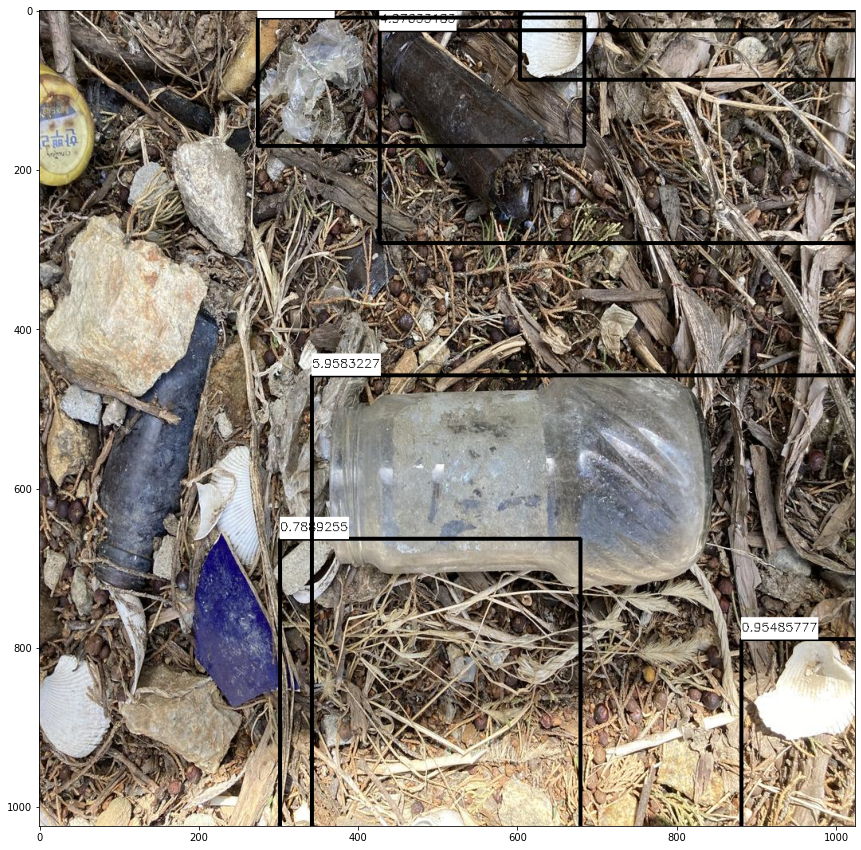

In [20]:
import math
plt.figure(figsize=(15,15))
bbox_inform = []
idx = 6
for i in range(len(submission)):
    if len(submission['PredictionString'].iloc[i].split(' ')[:-1]) % 6 == 0:
        dummy = [list(map(float, submission['PredictionString'].iloc[i].split(' ')[:-1])), submission['image_id'].iloc[i]]
        bbox_inform.append(dummy)
    # 바운딩 박스 사각형 그리기\
dataset_path = '../dataset/'
img = read_image(dataset_path, bbox_inform[idx][1])
for i in range(int(len(bbox_inform[idx][0]) / 6)):
    c, score, xmin, ymin, w, h = bbox_inform[idx][0][i * 6 : i * 6 + 6]
    xmin, ymin, w, h = int(xmin), int(ymin), int(w), int(h)
    if score > 0.75:
        img = cv2.rectangle(img, (xmin, ymin), (xmin + w, ymin + h), (0, 0, 0), 3)
        # 클래스 글자 넣기
        text_size, _ = cv2.getTextSize(str(c + score), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        text_w, text_h = text_size
        if xmin - text_h < 1:
            cv2.rectangle(img, (xmin, ymin), (xmin + text_w, ymin + 15 + text_h), [255,255,255], -1)
            img = cv2.putText(img, str(c + score), (xmin, ymin + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        else:
            cv2.rectangle(img, (xmin, ymin - 15 - text_h), (xmin + text_w, ymin), [255,255,255], -1)
            img = cv2.putText(img, str(c + score), (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
plt.imshow(img)